# Import audio file and convert to target tensor shape

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
TARGET_SAMPLE_RATE = 44_100
TARGET_SPLIT_DURATION_SEC = 10

In [3]:
file_path = '../raw_data/data_10s/train/Troglodytes-troglodytes-463329_tens.ogg'

## Import audio file into AudioTensor

In [4]:
def convert_audio_file_to_audio_tensor(filepath):
    '''
    Objective : import audio file as audio tensor with tensorflow IO
    Input : file path
    Output : AudioTensor, audio_rate
    '''
    audio = tfio.audio.AudioIOTensor(filepath)
    return audio

In [5]:
audio_tensor = convert_audio_file_to_audio_tensor(file_path)

## Convert to tensor, resample and optional split to keep first seconds

### Fonction

In [6]:
def convert_to_tensor(audio):
    '''
    Objective : convert AudioIOTensor to tf Tensor and keep track of audio sample rate
    Input : AudioIOTensor
    Output : tf.Tensor and audio sample rate (Hz - int)
    '''
    return audio[:], audio.rate.numpy()

In [7]:
real_tensor, real_tensor_audio_rate = convert_to_tensor(audio_tensor)

In [8]:
def resample_audio_tensor(tensor, audio_rate):
    '''
    Objective : resample audio file to 44_100 hz
    Input : tf.Tensor and original audio sample rate (Hz - int)
    Output : tf.Tensor resampled in 44_100 hz
    '''
    return tfio.audio.resample(tensor, audio_rate, TARGET_SAMPLE_RATE, name=None)

In [9]:
resampled_tensor = resample_audio_tensor(real_tensor, real_tensor_audio_rate)

In [10]:
def split_tensor(tensor, audio_rate):
    '''
    Objective : split to keep only first seconds of audio
    Input : tf.Tensor
    Output : tf.Tensor
    '''
    # Get split index adequate to audio rate
    split_index = audio_rate * TARGET_SPLIT_DURATION_SEC
    # Split if audio length > split_index
    if tensor.shape[0] > split_index :
        return tensor[:split_index]
    return tensor[:]

In [11]:
split = split_tensor(resampled_tensor, real_tensor_audio_rate)

### Tests

In [12]:
# Test avec son long et stereo
file = "../raw_data/subdataset_cs/train/Aegolius-funereus-131493.mp3"
audio1 = convert_audio_file_to_audio_tensor(file)
audio1, audio1_rate = convert_to_tensor(audio1)
audio1

<tf.Tensor: shape=(4437504, 2), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00],
       [ 9.5395428e-12,  1.0522362e-10],
       [ 2.2586129e-11,  9.0583104e-11],
       ...,
       [-5.5575853e-08,  4.8380411e-09],
       [-5.0935093e-08, -3.4454231e-09],
       [-3.9756735e-08, -1.3959095e-08]], dtype=float32)>

In [13]:
split1 = split_tensor(audio1,audio1_rate)
split1

<tf.Tensor: shape=(441000, 2), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00],
       [9.5395428e-12, 1.0522362e-10],
       [2.2586129e-11, 9.0583104e-11],
       ...,
       [8.8172196e-04, 9.6597435e-04],
       [9.7899744e-04, 1.2803953e-03],
       [1.3221783e-03, 1.7317437e-03]], dtype=float32)>

In [14]:
# Test avec son court et mono
audio2 = convert_audio_file_to_audio_tensor('gs://cloud-samples-tests/speech/brooklyn.flac')
audio2, audio2_rate = convert_to_tensor(audio2)
audio2

<tf.Tensor: shape=(28979, 1), dtype=int16, numpy=
array([[-184],
       [-181],
       [-156],
       ...,
       [  56],
       [  81],
       [  83]], dtype=int16)>

In [15]:
split2 = split_tensor(audio2,audio2_rate)
split2

<tf.Tensor: shape=(28979, 1), dtype=int16, numpy=
array([[-184],
       [-181],
       [-156],
       ...,
       [  56],
       [  81],
       [  83]], dtype=int16)>

## Reduce dimension

### Fonction

In [16]:
def harmonize_tensor_shape(audio):
    '''
    Objective : Harmonize tensor shape and dtype of audio to shape (x,),dtype=float32
    Input : tf.Tensor shape (x,2) stereo or (x,1) mono
    Output : tf.Tensor shape(x,)
    '''
    # Convert to float32 dtype if necessary
    if audio.dtype == tf.int16 :
        audio = tf.cast(audio, tf.float32) / 32768.0
    # Convert stero to mono if adequate :
    if audio.shape[1] == 2 :
        return tf.reduce_mean(audio, 1)
    # Remove last dimension if mono sound
    return tf.squeeze(audio, axis=[-1])

In [17]:
harmo_split = harmonize_tensor_shape(split)

In [18]:
harmo_split.shape[0]

160000

### Tests

In [19]:
# Test avec son long et stereo
split1

<tf.Tensor: shape=(441000, 2), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00],
       [9.5395428e-12, 1.0522362e-10],
       [2.2586129e-11, 9.0583104e-11],
       ...,
       [8.8172196e-04, 9.6597435e-04],
       [9.7899744e-04, 1.2803953e-03],
       [1.3221783e-03, 1.7317437e-03]], dtype=float32)>

In [20]:
reduced_split = harmonize_tensor_shape(split1)
reduced_split

<tf.Tensor: shape=(441000,), dtype=float32, numpy=
array([0.0000000e+00, 5.7381582e-11, 5.6584615e-11, ..., 9.2384813e-04,
       1.1296964e-03, 1.5269610e-03], dtype=float32)>

In [21]:
Audio(reduced_split.numpy(), rate=audio1_rate)

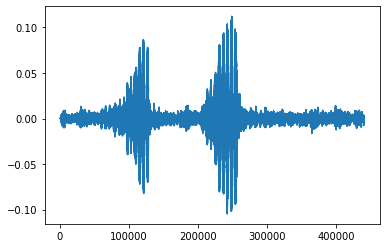

In [22]:
plt.plot(reduced_split.numpy());

In [23]:
# Test avec son court et mono
split2

<tf.Tensor: shape=(28979, 1), dtype=int16, numpy=
array([[-184],
       [-181],
       [-156],
       ...,
       [  56],
       [  81],
       [  83]], dtype=int16)>

In [24]:
reduced_split2 = harmonize_tensor_shape(split2)
reduced_split2

<tf.Tensor: shape=(28979,), dtype=float32, numpy=
array([-0.00561523, -0.00552368, -0.00476074, ...,  0.00170898,
        0.00247192,  0.00253296], dtype=float32)>

In [25]:
reduced_split2

<tf.Tensor: shape=(28979,), dtype=float32, numpy=
array([-0.00561523, -0.00552368, -0.00476074, ...,  0.00170898,
        0.00247192,  0.00253296], dtype=float32)>

In [26]:
Audio(reduced_split2.numpy(), rate=audio2_rate)

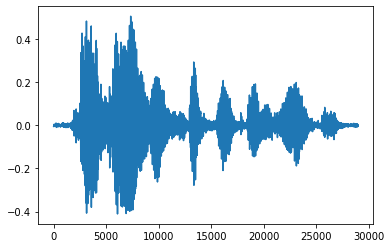

In [27]:
plt.plot(reduced_split2.numpy());

# Spectrogram

In [28]:
# On transpose pour avoir une shape similaire à celle de librosa en sortie
def generate_spectrogram(audio,nfft=2048,window=256,stride=256):
    '''
    Objective : Generate spectrogram
    Input : Audio tf.Tensor shape(x,)
    Ouput : Spectrogram tf.Tensor shape (x,y)
    '''
    spectrogram = tfio.audio.spectrogram(
        audio,
        nfft=nfft,
        window=window,
        stride=stride)
    return tf.transpose(spectrogram, perm=[1, 0])

In [29]:
spectro = generate_spectrogram(harmo_split)

In [30]:
spectro.shape

TensorShape([1025, 625])

In [31]:
2**12

4096

(1025, 1723)


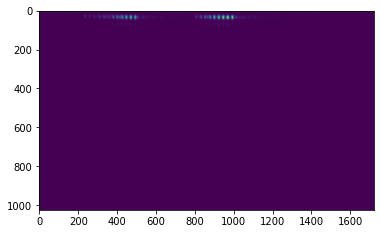

In [32]:
# Convert to spectrogram
spectrogram = generate_spectrogram(reduced_split)
print(spectrogram.shape)
plt.imshow((spectrogram).numpy());

(2049, 1723)


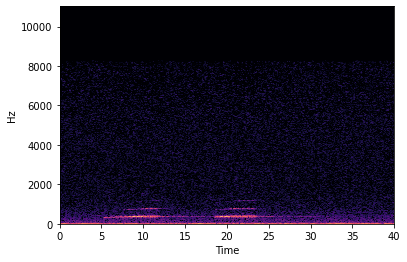

In [33]:
# Comparaison librosa
import librosa
import librosa.display
import numpy as np
spectro = librosa.stft(reduced_split.numpy(),n_fft=4096,hop_length=256)
print(spectro.shape)
S_db = librosa.amplitude_to_db(np.abs(spectro), ref=np.max)
librosa.display.specshow(S_db, y_axis='hz', x_axis='time');

In [34]:
def generate_mel_spectrogram(spectrogram,rate=44100, mels=128, fmin=0, fmax=8000):
    '''
    Objective : Convert to mel spectrogram
    Input : Spectrogram tf.Tensor shape (x,y)
    Ouput : Spectrogram tf.Tensor shape (x,y)
    '''
    mel_spectrogram = tfio.audio.melscale(
        spectrogram,
        rate=rate,
        mels=mels,
        fmin=0,
        fmax=8000)
    return mel_spectrogram

(1025, 128)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

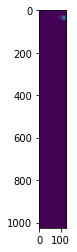

In [35]:
mel_spectrogram = generate_mel_spectrogram(spectrogram)
print(mel_spectrogram.shape)
plt.imshow((mel_spectrogram).numpy());
plt.figure

In [36]:
def generate_db_scale_mel_spectrogram(mel_spectrogram, top_db=80):
    '''
    Objective : Convert to db scale spectrogram
    Input : Spectrogram tf.Tensor shape (x,y)
    Ouput : Spectrogram tf.Tensor shape (x,y)
    '''
    db_scale_mel_spectrogram = tfio.audio.dbscale(
        mel_spectrogram,
        top_db=80)
    return db_scale_mel_spectrogram

(1025, 128)


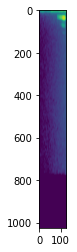

In [37]:
db_scale_spectrogram = generate_db_scale_mel_spectrogram(mel_spectrogram)
print(db_scale_spectrogram.shape)
plt.imshow((db_scale_spectrogram).numpy());